# Setup

Getting things ready

In [0]:
!pip install fastai2

In [0]:
# Some useful imports
import pandas as pd
import numpy as np
import fastai2
from fastai2.vision.all import *
from sklearn.metrics import log_loss as skll
from PIL import Image as PImage
import random
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('fivethirtyeight')
%matplotlib inline

from skimage import io, color

In [0]:
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/all_classes.txt

In [0]:
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/test-images.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-images.npy

In [0]:
!ls *.npy

test-images.npy  train-images.npy  train-labels.npy


In [0]:
train_labels = np.load('train-labels.npy')
train_labels.shape, train_labels[0]

((43466,), 7)

In [0]:
train_ims = np.load('train-images.npy')
train_ims.shape, train_ims[0].shape

((43466, 32, 32, 3), (32, 32, 3))

In [0]:
test_ims = np.load('test-images.npy')
test_ims.shape, test_ims[0].shape

((10838, 32, 32, 3), (32, 32, 3))

In [0]:
ims = np.concatenate([train_ims, test_ims])
ims.shape

(54304, 32, 32, 3)

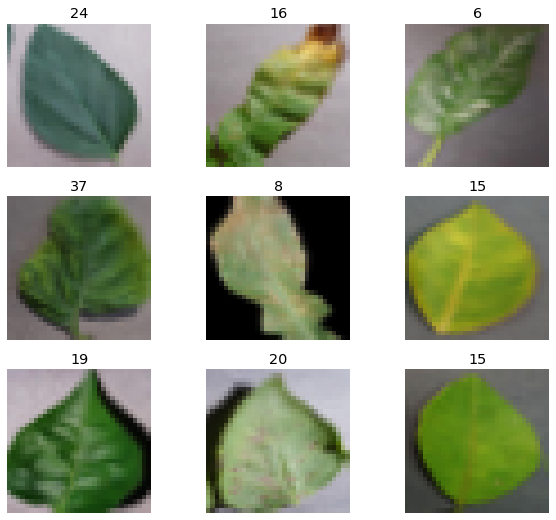

In [0]:
# Get the image:
def get_x(ID):
  return ims[ID]

# And the label
def get_y(ID):
  return train_labels[ID]

# Get the list of Image IDS:
def get_im_ids(path):
  return range(len(train_ims))

# And build the datablock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_im_ids,
    get_x=get_x,
    get_y=get_y, 
    splitter=RandomSplitter(valid_pct=0.00001),
    batch_tfms=aug_transforms(size=32)
)
dls = dblock.dataloaders(Path(''), bs=64)
dls.show_batch()

With the dataloaders created, making and training a model can be as simple as:

In [0]:
# Create the learner
learn = cnn_learner(dls, resnet101, metrics=[accuracy, top_k_accuracy])

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [0]:
learn.fine_tune(5)  

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.529585,3.215905,0.666590,0.911643,02:07


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.587002,0.441423,0.858030,0.984583,02:40
1,0.405581,0.361215,0.887253,0.990106,02:39
2,0.256315,0.196328,0.938794,0.996318,02:40
3,0.167112,0.147036,0.950069,0.997929,02:39
4,0.105368,0.138609,0.952830,0.997469,02:37


Now that we have a baseline model trained, we need to save predicitons for a submission.

In [0]:
learn.fine_tune(1)

In [0]:
# Create a test dataloader and get predictions
idxs = [i + len(train_ims) for i in range(len(test_ims))]
tdl = learn.dls.test_dl(idxs)
test_preds, test_labels = learn.tta(dl=tdl) # Using test time augmentation. Replace tta with get_preds for simpler inference.

In [0]:
# Get the predicted classes based on the probabilities
pred_classes = [int(np.argmax(t)) for t in test_preds]

In [0]:
# Make a submission dataframe
sub = pd.DataFrame({
    'class_index':pred_classes
})
sub.head()

,class_index
0,37
1,30
2,34
3,30
4,6


In [0]:
# Save and submit
sub.to_csv('submission.csv', index=False)
sub.to_csv('submission_baseline.csv', index=False)

# Places to improve

- What data augmentations make sense for this chalenge? The default do horizantal flips and slight transforms. But do leaves have an orientation? Would vertical flips make sense? Zooms/crops on these tiny images might not be as useful as they are on larger images, etc.
- Training: fine_tune() is fine for a first pass, but you might want to try the lr_find method to pick a learning rate, train the head, unfreeze, train the rest... basically follow a more thorough training process (see the fastai course etc for examples)
- Model: feel free to try different models.
- Try an ensemble with several models
- ... :)

Good luck!

In [0]:
learn2 = cnn_learner(dls, densenet121, metrics=[accuracy])

In [0]:
learn2.fine_tune(9) 

epoch,train_loss,valid_loss,accuracy,time
0,0.956928,None,None,01:22


/usr/local/lib/python3.6/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,accuracy,time
0,0.571460,None,None,01:36
1,0.425748,None,None,01:35
2,0.312704,None,None,01:38
3,0.252537,None,None,01:36
4,0.179288,None,None,01:35
5,0.147737,None,None,01:34
6,0.117459,None,None,01:34
7,0.086454,None,None,01:34
8,0.082005,None,None,01:34


In [0]:
learn2.fine_tune(10) 

epoch,train_loss,valid_loss,accuracy,time
0,0.026724,None,None,01:34


/usr/local/lib/python3.6/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,accuracy,time
0,0.025924,None,None,01:36
1,0.028268,None,None,01:35
2,0.034722,None,None,01:35
3,0.042843,None,None,01:35
4,0.038185,None,None,01:35
5,0.035405,None,None,01:36
6,0.020576,None,None,01:35
7,0.013659,None,None,01:36
8,0.009142,None,None,01:35
9,0.013584,None,None,01:35


In [0]:
# Create a test dataloader and get predictions
idxs = [i + len(train_ims) for i in range(len(test_ims))]
tdl = learn2.dls.test_dl(idxs)
test_preds, test_labels = learn2.tta(dl=tdl) # Using test time augmentation. Replace tta with get_preds for simpler inference.

In [0]:
# Get the predicted classes based on the probabilities
pred_classes = [int(np.argmax(t)) for t in test_preds]

In [0]:
# Make a submission dataframe
sub = pd.DataFrame({
    'class_index':pred_classes
})
sub.head()

,class_index
0,37
1,30
2,34
3,30
4,6


In [0]:
# Save and submit
sub.to_csv('submission.csv', index=False)
sub.to_csv('submission_baseline.csv', index=False)

In [0]:
sub.to_csv('densenet20.csv', index=False) 

In [0]:
import torchvision.models as TorchModels

In [0]:
learn3 = cnn_learner(dls, squeezenet1_1, metrics=[accuracy, top_k_accuracy])

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth
